# Question 4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


class CNN(nn.Module):
    def __init__(self, n_filters, size_filters, size_fc, activation='relu', filter_organization='double', batch_normalization='yes', dropout=0.0):
        super(CNN, self).__init__()

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'gelu':
            self.activation = F.gelu
        elif activation == 'silu':
            self.activation = F.silu
        elif activation == 'mish':
            self.activation = self.mish
        else:
            raise ValueError("Invalid activation function. Choose from 'relu', 'gelu', 'silu', 'mish'.")

        if batch_normalization == 'yes':
            self.use_batch_norm = True
        else:
            self.use_batch_norm = False

        self.dropout_rate = dropout  # Set dropout rate

        if filter_organization == 'same':
            filter_sizes = [n_filters] * 5  # Same number of filters in all layers
        elif filter_organization == 'double':
            filter_sizes = [n_filters * (2**i) for i in range(5)]  # Double filters in each subsequent layer
        elif filter_organization == 'halve':
            filter_sizes = [n_filters // (2**i) for i in range(5)]  # Halve filters in each subsequent layer
        else:
            raise ValueError("Invalid filter organization. Choose from 'same', 'double', 'halve'.")

        self.conv1 = nn.Conv2d(3, filter_sizes[0], kernel_size=size_filters)
        if self.use_batch_norm:
            self.bn1 = nn.BatchNorm2d(filter_sizes[0])
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(filter_sizes[0], filter_sizes[1], kernel_size=size_filters)
        if self.use_batch_norm:
            self.bn2 = nn.BatchNorm2d(filter_sizes[1])
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(filter_sizes[1], filter_sizes[2], kernel_size=size_filters)
        if self.use_batch_norm:
            self.bn3 = nn.BatchNorm2d(filter_sizes[2])
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(filter_sizes[2], filter_sizes[3], kernel_size=size_filters)
        if self.use_batch_norm:
            self.bn4 = nn.BatchNorm2d(filter_sizes[3])
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(filter_sizes[3], filter_sizes[4], kernel_size=size_filters)
        if self.use_batch_norm:
            self.bn5 = nn.BatchNorm2d(filter_sizes[4])
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(p=self.dropout_rate)  # Dropout layer with specified rate

        self.fc_input_size = self._get_fc_input_size(size_filter_last=filter_sizes[4], kernel_conv=size_filters)

        self.fc1 = nn.Linear(self.fc_input_size, size_fc)
        self.fc2 = nn.Linear(size_fc, 10)

    def _get_fc_input_size(self, size_filter_last, stride_conv=1, stride_pool=2, kernel_conv=5, kernel_pool=2, input_size=244):
        for _ in range(5):  # Number of conv-pool layers
            input_size = ((input_size - kernel_conv) // stride_conv) + 1  # Adjusted for kernel size and stride of conv layers
            input_size = ((input_size - kernel_pool) // stride_pool) + 1  # Adjusted for kernel size, stride, and pooling of pool layers
        return size_filter_last * input_size * input_size

    def forward(self, x):
        x = self.pool1(self.activation(self.bn1(self.conv1(x)))) if self.use_batch_norm else self.pool1(self.activation(self.conv1(x)))
        x = self.pool2(self.activation(self.bn2(self.conv2(x)))) if self.use_batch_norm else self.pool2(self.activation(self.conv2(x)))
        x = self.pool3(self.activation(self.bn3(self.conv3(x)))) if self.use_batch_norm else self.pool3(self.activation(self.conv3(x)))
        x = self.pool4(self.activation(self.bn4(self.conv4(x)))) if self.use_batch_norm else self.pool4(self.activation(self.conv4(x)))
        x = self.pool5(self.activation(self.bn5(self.conv5(x)))) if self.use_batch_norm else self.pool5(self.activation(self.conv5(x)))

        x = self.dropout(x) if self.dropout_rate > 0 else x

        x = x.view(-1, self.fc_input_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def mish(self, x):
        return x * torch.tanh(F.softplus(x))


n_filters=64
filter_organization='same'
fc_layer=128
data_augment='no'
activation='gelu'
batch_normalization='yes'
dropout=0.3

#Fixed hyperparameters
batch_size=32
num_epochs=5
learning_rate=1e-3
filter_size=5

if data_augment == 'yes':
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.RandomRotation(10),  # Randomly rotate the image by up to 10 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue randomly
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
else:
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

vanilla_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = ImageFolder('/kaggle/input/dataset/inaturalist_12K/train', transform=train_transform)
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, shuffle=True, stratify=dataset.targets)
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

test_dataset = ImageFolder('/kaggle/input/dataset/inaturalist_12K/val', transform=vanilla_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)





model = CNN(n_filters=n_filters, size_filters=filter_size, size_fc=fc_layer, activation=activation, filter_organization=filter_organization, batch_normalization=batch_normalization, dropout=dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
if torch.cuda.is_available():
    model=model.cuda()
    criterion=criterion.cuda()

n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()

        # Forward pass
        outputs = model(images)
        train_loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    print(f'At end of epoch [{epoch+1}/{num_epochs}], training loss: {train_loss.item():.4f}')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            val_loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f'At end of epoch [{epoch+1}/{num_epochs}], validation loss: {val_loss.item():.4f}, validation acuracy: {val_accuracy:.2f}%')


print('Finished Training')
# Test phase
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Test accuracy: {test_accuracy:.2f}%')

At end of epoch [1/5], training loss: 1.9217
At end of epoch [1/5], validation loss: 2.1934, validation acuracy: 24.60%
At end of epoch [2/5], training loss: 1.9670
At end of epoch [2/5], validation loss: 1.9541, validation acuracy: 27.60%
At end of epoch [3/5], training loss: 1.9692
At end of epoch [3/5], validation loss: 2.0378, validation acuracy: 32.25%
At end of epoch [4/5], training loss: 1.7899
At end of epoch [4/5], validation loss: 1.6226, validation acuracy: 33.65%
At end of epoch [5/5], training loss: 1.6206
At end of epoch [5/5], validation loss: 1.3904, validation acuracy: 33.75%
Finished Training
Test accuracy: 34.35%


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


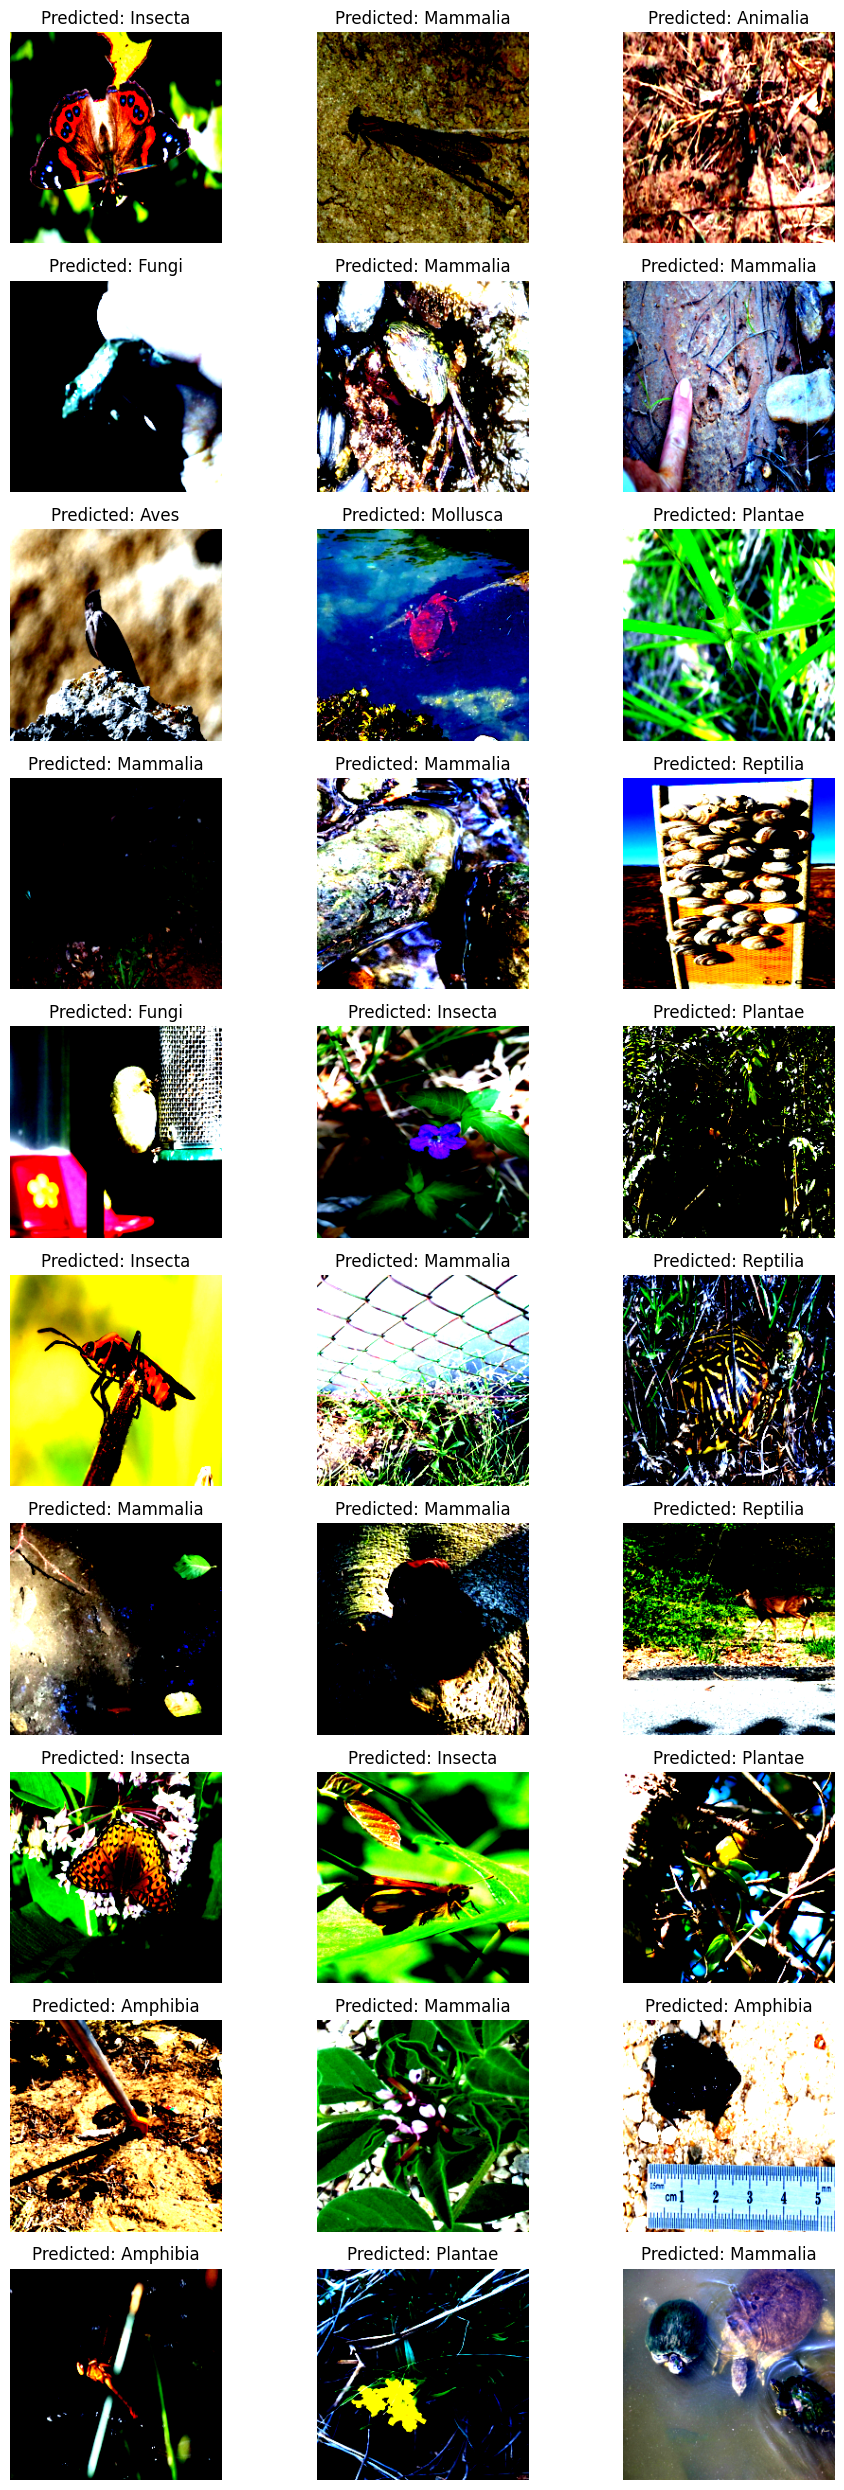

ValueError: min() arg is an empty sequence

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

import wandb  # Import wandb library
wandb.login(key='4734e60951ce310dbe17484eeeb5b3366b54850f')
wandb.init(project='CS6910_assignment_2', entity='sumanta_roy')


# Test phase
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    # Convert the test dataset to a list and then randomly sample 30 images
    test_samples = random.sample(list(test_dataset), 30)

    fig, axs = plt.subplots(10, 3, figsize=(10, 25))
    axs = axs.ravel()

    for idx, (image, label) in enumerate(test_samples):
        # Prepare the image for prediction
        image = image.unsqueeze(0).cuda()  # Add batch dimension and move to GPU if available

        # Get the model's prediction
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        prediction = predicted.item()

        # Display the image and prediction (class names)
        image = image.squeeze(0)  # Remove batch dimension
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert from tensor to numpy array and transpose dimensions
        image = np.clip(image, 0, 1)  # Clip values to [0, 1] for display purposes

        axs[idx].imshow(image)
        axs[idx].set_title(f'Predicted: {test_dataset.classes[prediction]}')
        axs[idx].axis('off')

        total += 1
        if prediction == label:
            correct += 1

    plt.tight_layout()
    plt.show()

    # Log the chart to WandB
    wandb.log({"chart": plt})

# Calculate test accuracy
test_accuracy = 100 * correct / total

# Log the test accuracy to WandB
wandb.log({"Test Accuracy": test_accuracy})

print(f'Test accuracy on sampled images: {test_accuracy:.2f}%')

In [ ]:
plt.savefig('predictions.png')

<Figure size 640x480 with 0 Axes>